In [1]:
%run _common.ipynb
from jax import Array
import jax.numpy as jnp
import equinox as eqx
import optax
import numpy as np
import matplotlib.pyplot as plt

from neuralconstitutive.constitutive import FromLogDiscreteSpectrum
from neuralconstitutive.relaxation_spectrum import HonerkampWeeseBimodal
from neuralconstitutive.pyRespect import estimate_continous_spectrum
from neuralconstitutive.jax.tipgeometry import Spherical, AbstractTipGeometry
from neuralconstitutive.trajectory import Trajectory, make_triangular
from neuralconstitutive.jax.ting import force_approach, force_retract
from neuralconstitutive.nn import FullyConnectedNetwork
from neuralconstitutive.models import BernsteinNN

2023-11-29 04:11:25.596094: W external/xla/xla/service/gpu/nvptx_compiler.cc:679] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.103). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


## 1. Mock data generation

We use the bimodal log-Gaussian model first introduced in J. Honerkamp and J. Weese, Macromolecules (1989).

We plot the spectrum below:

Text(0, 0.5, 'Relaxation Spectrum H(τ)[Pa]')

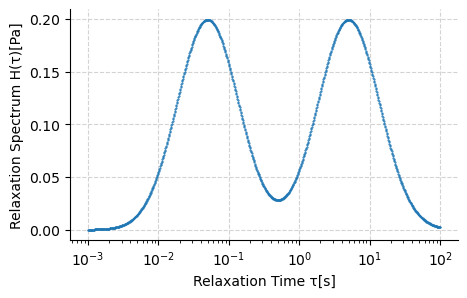

In [2]:
bimodal = FromLogDiscreteSpectrum(HonerkampWeeseBimodal())

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(*bimodal.discrete_spectrum, ".")
ax.set_xscale("log", base=10)
ax.set_xlabel("Relaxation Time τ[s]")
ax.set_ylabel("Relaxation Spectrum H(τ)[Pa]")

Given a sufficiently densely sampled relaxation spectrum $\{\tau_i, h_i\}_{i=0}^N$, where $h_i = H(\tau=\tau_i)$,

the relaxation function can be approximated by the following equation:
\begin{equation}
G(t) = \sum_{i=0}^N g_i e^{-t/\tau_i}; \quad g_i = h_i\cdot h_0
\end{equation}
where $h_0 = \frac{\log(\tau_N)-\log(\tau_0)}{N}$

Text(0, 0.5, 'Relaxation Function[Pa]')

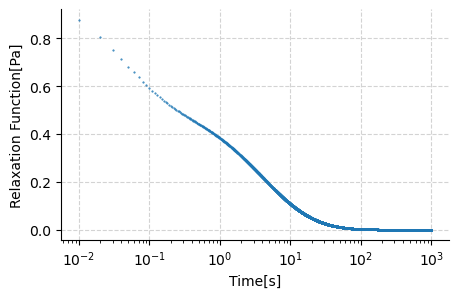

In [3]:
t_data = np.linspace(0, 1e3, 100000)[1:]  # to avoid t=0
g_data = bimodal.relaxation_function(t_data)

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(t_data, g_data, ".")
ax.set_xscale("log", base=10)
ax.set_xlabel("Time[s]")
ax.set_ylabel("Relaxation Function[Pa]")

## 2. Run pyRespect on the mock data

Here, we run our refactored version of pyRespect on the mock data.

The original pyRespect code first interpolates the data points onto 100 log-equi-spaced grid points before the main algorithm.

Here, the code has been tweaked so that either the interpolation can be turned off, or the number of grid points be changed.

However, note that too many time points can result in a memory overflow error (or greatly slow down the algorithm). 

Interpolating t, G to 100 points
Interpolating t, G to 200 points
Interpolating t, G to 500 points


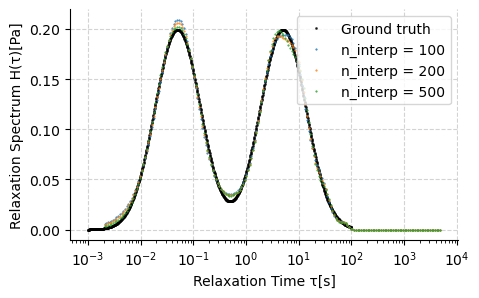

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(
    *bimodal.discrete_spectrum,
    ".",
    color="black",
    markersize=2.0,
    alpha=0.7,
    label="Ground truth",
)
for n_interp in (100, 200, 500):
    t_estimated, h_estimated, _ = estimate_continous_spectrum(
        t_data, g_data, n_interpolation=n_interp, n_spectrum_points=200
    )
    ax.plot(
        t_estimated,
        h_estimated,
        ".",
        alpha=1.0,
        label=f"n_interp = {n_interp}",
    )
ax.set_xscale("log", base=10)
ax.set_xlabel("Relaxation Time τ[s]")
ax.set_ylabel("Relaxation Spectrum H(τ)[Pa]")
ax.legend()

## 3. Calculate force curve corresponding to the mock data

In [5]:
tip = Spherical(1.0)
Dt = 1e-2
app, ret = make_triangular(1.0, 1e-2, 10.0)

f_app = force_approach(app, bimodal.relaxation_function, tip)
f_ret = force_retract(app, ret, bimodal.relaxation_function, tip)

Text(0.5, 0, 'Time')

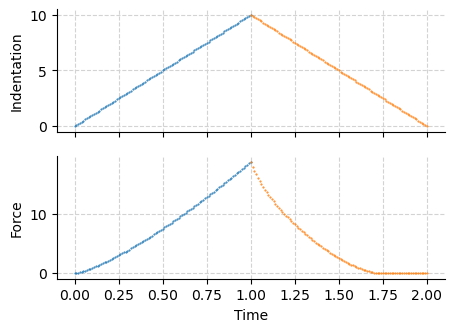

In [6]:
fig, axes = plt.subplots(2, 1, figsize=(5, 3.5), sharex=True)
axes[0].plot(app.t, app.z(app.t), ".")
axes[0].plot(ret.t, ret.z(ret.t), ".")
axes[0].set_ylabel("Indentation")

axes[1].plot(app.t, f_app, ".")
axes[1].plot(ret.t, f_ret, ".")
axes[1].set_ylabel("Force")
axes[1].set_xlabel("Time")

## 4. Train neural network on the simulated force data

Text(0.5, 1.0, 'NN prediction before training')

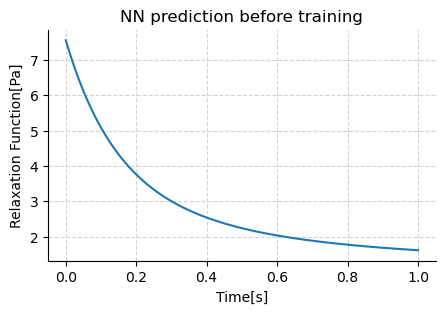

In [7]:
fcn = FullyConnectedNetwork(
    ["scalar", 20, 20, 20, 20, "scalar"],
)
phi_bern = BernsteinNN(fcn, 100)

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(app.t, phi_bern(app.t))
ax.set_xlabel("Time[s]")
ax.set_ylabel("Relaxation Function[Pa]")
ax.set_title("NN prediction before training")

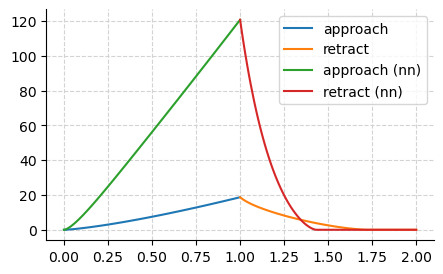

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
f_app_pred = force_approach(app, phi_bern, tip)
f_ret_pred = force_retract(app, ret, phi_bern, tip)
ax.plot(app.t, f_app, label="approach")
ax.plot(ret.t, f_ret, label="retract")
ax.plot(app.t, f_app_pred, label="approach (nn)")
ax.plot(ret.t, f_ret_pred, label="retract (nn)")
ax.legend()

In [10]:
# Define functions to train the neural network
## TODO: think of a better abstraction
@eqx.filter_value_and_grad
def compute_loss(
    model: eqx.Module,
    app: Trajectory,
    ret: Trajectory,
    F_app: Array,
    F_ret: Array,
    tip: AbstractTipGeometry,
):
    F_app_pred = force_approach(app, model, tip)
    F_ret_pred = force_retract(app, ret, model, tip)
    # Mean squared error loss
    # l1 = jnp.sum(jnp.abs(model.weights)) + jnp.abs(model.bias)
    return jnp.mean((F_app - F_app_pred) ** 2) + jnp.mean((F_ret - F_ret_pred) ** 2)


## TODO: avoid using global variables
model = phi_bern
optim = optax.rmsprop(1e-3)
opt_state = optim.init(model)


@eqx.filter_jit
def make_step(
    model: eqx.Module,
    app: Trajectory,
    ret: Trajectory,
    F_app: Array,
    F_ret: Array,
    tip: AbstractTipGeometry,
    opt_state,
):
    loss, grads = compute_loss(model, app, ret, F_app, F_ret, tip)
    updates, opt_state = optim.update(grads, opt_state, params=model)
    model = eqx.apply_updates(model, updates)
    return loss, model, opt_state

In [11]:
max_epochs = 1000
loss_history = np.empty(max_epochs)
for step in range(max_epochs):
    loss, model, opt_state = make_step(model, app, ret, f_app, f_ret, tip, opt_state)
    loss = loss.item()
    loss_history[step] = loss
    print(f"step={step}, loss={loss}")


step=0, loss=4115.292993675297
step=1, loss=3786.8828585103884
step=2, loss=3569.1031710465504
step=3, loss=3393.289755537722
step=4, loss=3238.983885467069
step=5, loss=3099.5358156626166
step=6, loss=2971.546442495816
step=7, loss=2852.8614876612214
step=8, loss=2742.4416102186105
step=9, loss=2639.874542889045
step=10, loss=2544.2512048305753
step=11, loss=2456.0539818302977
step=12, loss=2374.1050743786077
step=13, loss=2298.318672975092
step=14, loss=2228.343311269754
step=15, loss=2163.7496248241837
step=16, loss=2103.974286675535
step=17, loss=2048.797812910947
step=18, loss=1997.8842707096749
step=19, loss=1950.7077891028305
step=20, loss=1907.235006719722
step=21, loss=1866.7372514966412
step=22, loss=1829.4236121312085
step=23, loss=1794.8849829868577
step=24, loss=1762.6283980132273
step=25, loss=1732.5959339701112
step=26, loss=1704.535511183672
step=27, loss=1678.4124022976475
step=28, loss=1653.8770106553754
step=29, loss=1630.9400386977063
step=30, loss=1609.294143116032

## 5. Inspect training results

Text(0.5, 0, 'Time $t$ (a.u.)')

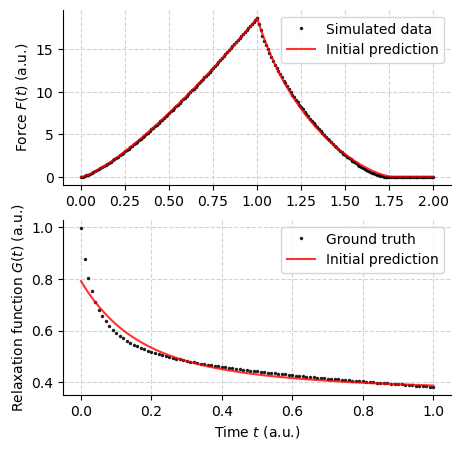

In [13]:
# %%
F_app = force_approach(app, model, tip)
F_ret = force_retract(app, ret, model, tip)

plot_kwargs = {"markersize": 3.0, "alpha": 0.8}
fig, axes = plt.subplots(2, 1, figsize=(5, 5))

axes[0].plot(app.t, f_app, ".", color="k", label="Simulated data", **plot_kwargs)
axes[0].plot(ret.t, f_ret, ".", color="k", **plot_kwargs)
# axes[0].plot(t_app, F_app, "-", color="royalblue", label="Prediction", **plot_kwargs)
# axes[0].plot(t_ret, F_ret, "-", color="royalblue", **plot_kwargs)
axes[0].plot(app.t, F_app, "-", color="red", label="Initial prediction", **plot_kwargs)
axes[0].plot(ret.t, F_ret, "-", color="red", **plot_kwargs)
axes[0].set_ylabel("Force $F(t)$ (a.u.)")

axes[1].plot(
    app.t,
    bimodal.relaxation_function(app.t),
    ".",
    color="k",
    label="Ground truth",
    **plot_kwargs,
)
axes[1].set_ylabel("Relaxation function $G(t)$ (a.u.)")
# axes[1].plot(
#     t_app,
#     jax.vmap(model)(t_app),
#     "-",
#     color="royalblue",
#     label="Extracted",
#     **plot_kwargs,
# )
axes[1].plot(
    app.t,
    model(app.t),
    "-",
    color="red",
    label="Initial prediction",
    **plot_kwargs,
)


for ax in axes:
    ax.grid(color="lightgray", linestyle="--")
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    ax.legend()
axes[-1].set_xlabel("Time $t$ (a.u.)")

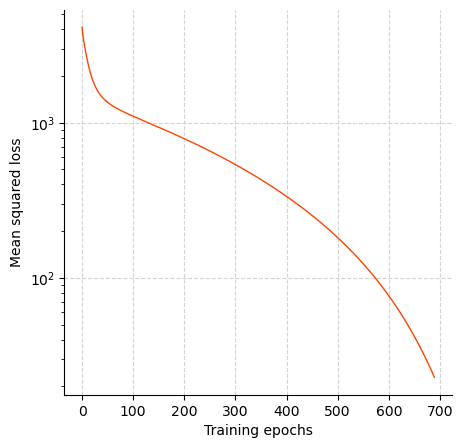

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(loss_history[:690], color="orangered", linewidth=1.0)
ax.set_xlabel("Training epochs")
ax.set_ylabel("Mean squared loss")
ax.set_yscale("log")
ax.grid(color="lightgray", linestyle="--")
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)